# Zillow Clustering: Final Notebook

## Carolyn Davis 

# 09/28/2021

### Project Goals:

### Use clustering methodologies to identif drivers of logerror in Zillow Zestimates
### Create modules storing functions of each step of the data pipeline
### Thoroughly document each step
### Construct at least 4 models, 1 of which must outperform the baseline
### Make sure the project can be recreated

### -Deliverables:
#### Final Report Notebook detailing all of my findings and methodologies
    Modules commented out with appropriate functions to replicate each stage of the DS pipeline
    README file that details the project specs, planning, key findings, and steps to reproduce

## Project Planning

In [ ]:
# -Write a SQL query, and put in function to acquire data from Zillow dataset on Codeup database
# -Create a prepare.py module complete with all necessary functions to clean the data
# -Use visualizations and statistical testing to explore relationships between variables and logerror
# -Use key variables to create clusters, and perform statistical testing on clusters to see if they are useful
# -Establish a baseline model, and compute its RMSE
# -Use key variables and clusters to create 4 models, with the aim of outperforming the baseline
# -Use best model on test data
# -draw conclusions at each step of the pipeline


In [1]:
import acquire as a 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

import sklearn.preprocessing

from scipy import stats

from sklearn.metrics import mean_squared_error

from sklearn.metrics import explained_variance_score

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import pearsonr, spearmanr

# import visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math



from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans


# import modeling tools
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

import func as f
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Acquisition
Connecting to the Codeup SQL database, the data will be acquired using pd.read_sql and a custom made function that will cache the data in a CSV if one does not already exist. It will then be checked for null values within the columns and summarized prior to preparation.

In [2]:
# create variable to hold SQL query

zillow_df = a.get_all_zillow_data()
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77580 entries, 0 to 77579
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        223 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77580 non-null  float64
 3   heatingorsystemtypeid         49572 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      207 non-null    float64
 6   airconditioningtypeid         25007 non-null  float64
 7   parcelid                      77580 non-null  int64  
 8   id                            77580 non-null  int64  
 9   logerror                      77580 non-null  float64
 10  transactiondate               77580 non-null  object 
 11  id.1                          77580 non-null  int64  
 12  basementsqft                  50 non-null     float64
 13  b

In [3]:
f.get_nulls(zillow_df)

<class 'pandas.core.series.Series'>


(                        num_rows_missing  percent_rows_missing
 typeconstructiontypeid             77357             99.712555
 storytypeid                        77530             99.935550
 propertylandusetypeid                  0              0.000000
 heatingorsystemtypeid              28008             36.102088
 buildingclasstypeid                77565             99.980665
 ...                                  ...                   ...
 buildingclassdesc                  77565             99.980665
 heatingorsystemdesc                28008             36.102088
 propertylandusedesc                    0              0.000000
 storydesc                          77530             99.935550
 typeconstructiondesc               77357             99.712555
 
 [69 rows x 2 columns],
    num_cols_missing percent_cols_missing  num_rows
 0                23    33.33333333333333         2
 1                24    34.78260869565217        13
 2                25   36.231884057971016        2

In [4]:
#Replace a whitespace sequence or empty with a NaN value and reassign this manipulation to df:
zillow_df = zillow_df.replace(r'^\s*S', np.nan, regex=True)
zillow_df = zillow_df.drop_duplicates()

In [5]:
col_list = ['id', 'transactiondate',
            'id.1', 'propertycountylandusecode', 'rawcensustractandblock',
            'assessmentyear', 'roomcnt', 'calculatedbathnbr', 'finishedsquarefeet12']
zillow_df = f.drop_columns(zillow_df, col_list)

In [6]:
zillow_df = f.drop_null_values(zillow_df)

In [7]:
# drop all rows with null values for any tax fields
zillow_df = zillow_df[zillow_df.taxvaluedollarcnt.isnull() == False]
zillow_df = zillow_df[zillow_df.landtaxvaluedollarcnt.isnull() == False]
zillow_df = zillow_df[zillow_df.structuretaxvaluedollarcnt.isnull() == False]
zillow_df = zillow_df[zillow_df.taxamount.isnull() == False]
# Dropping any rows with low count of nulls   

#dropping lotsizesquarefeet, too many nulls, 
zillow_df = zillow_df[zillow_df.fullbathcnt.isnull() == False]
zillow_df = zillow_df[zillow_df.yearbuilt.isnull() == False]
zillow_df = zillow_df[zillow_df.calculatedfinishedsquarefeet.isnull() == False]
zillow_df = zillow_df[zillow_df.censustractandblock.isnull() == False]


#Dropping these columns bc they either have too many nulls or are 
dropped = ['lotsizesquarefeet', 'fullbathcnt']
zillow_df = zillow_df.drop(columns=dropped)

In [8]:
#Renaming the Columns
zillow_df = zillow_df.rename(columns={'parcelid': 'parcel_id', 'logerror': 'target', 
                            'bathroomcnt': 'bath_count', 'bedroomcnt': 'bed_count', 
                            'calculatedfinishedsquarefeet': 'sq_footage', 
                            'censustractandblock': 'census_tract', 
                            'yearbuilt': 'year_built', 'taxvaluedollarcnt': 'property_value', 
                            'taxamount': 'tax_amount', 'structuretaxvaluedollarcnt': 'structure_value',
                            'landtaxvaluedollarcnt': 'land_value'})

## Creating New Features:


In [9]:
zillow_df = f.get_counties(zillow_df)


In [10]:
zillow_df = f.create_features(zillow_df)

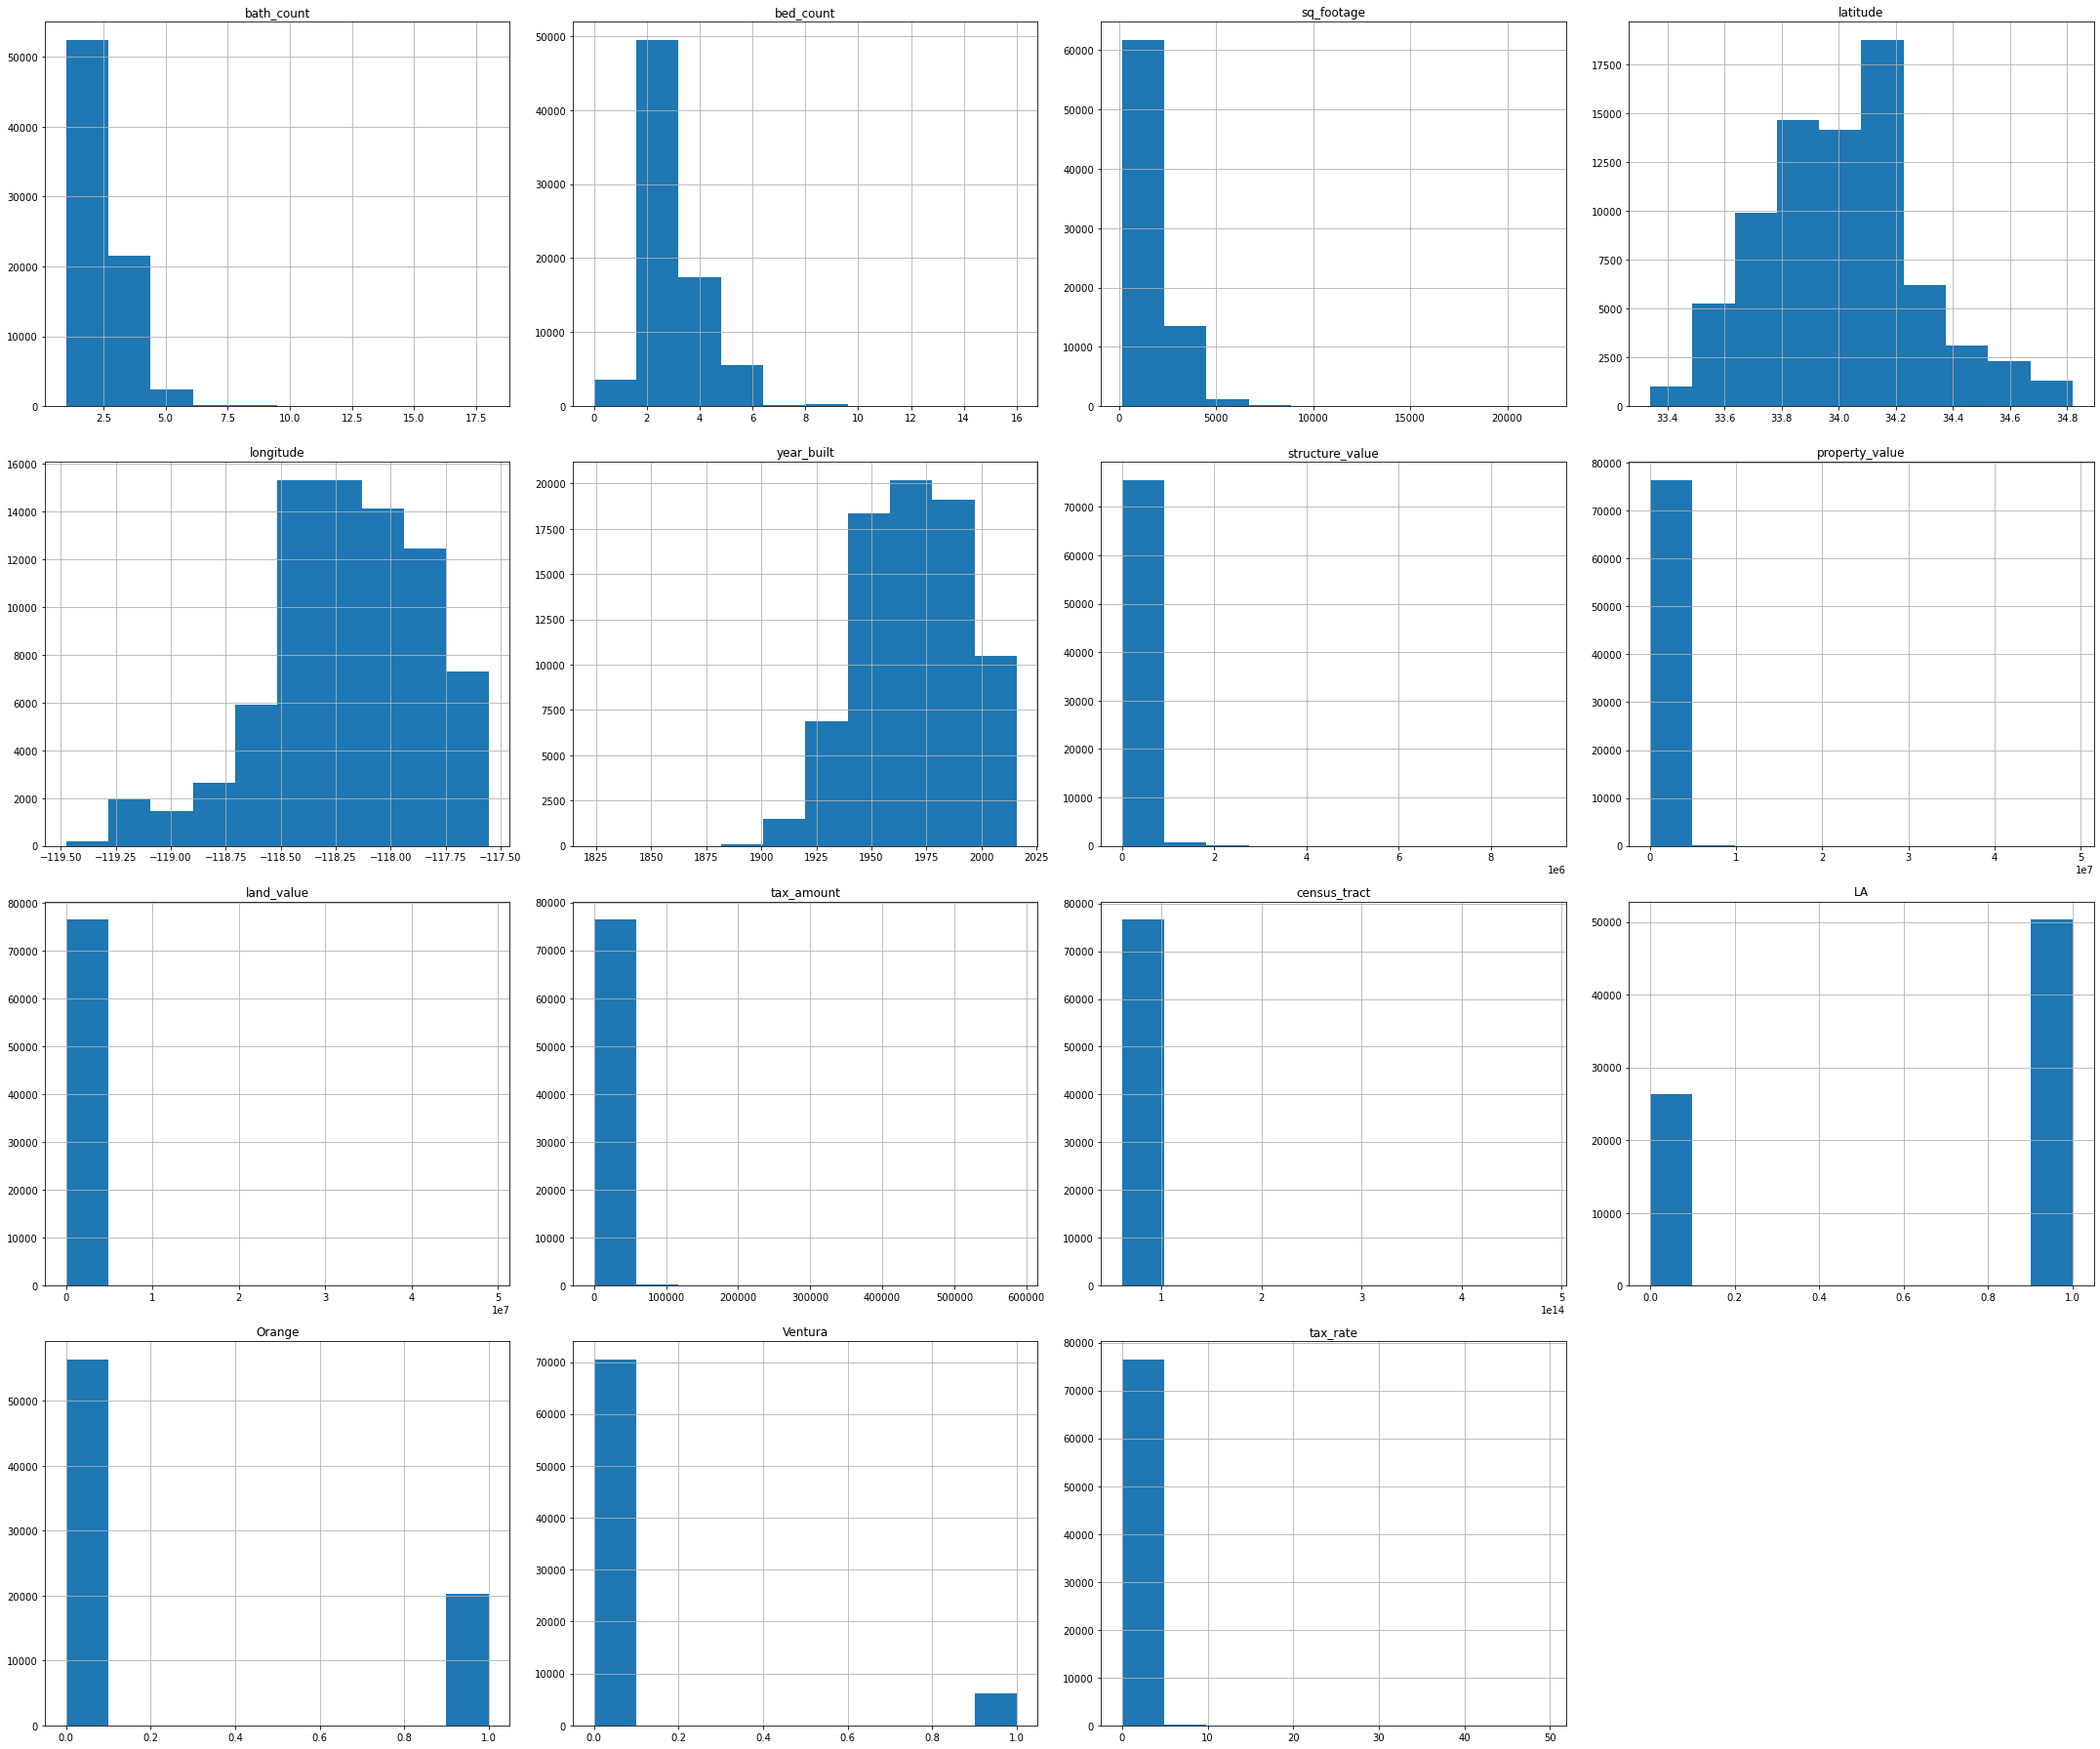

In [11]:
# visualize distributions
zillow_df.drop(columns=['target', 'parcel_id']).hist(figsize=(30,25))
plt.tight_layout()
plt.show()

In [12]:
# assign columns to remove IQR outliers from
outlier_cols = ['land_value', 'property_value',
                'structure_value', 'tax_amount', 'sq_footage']


zillow_df = f.shed_iqr_outliers(zillow_df, col_list=outlier_cols) 

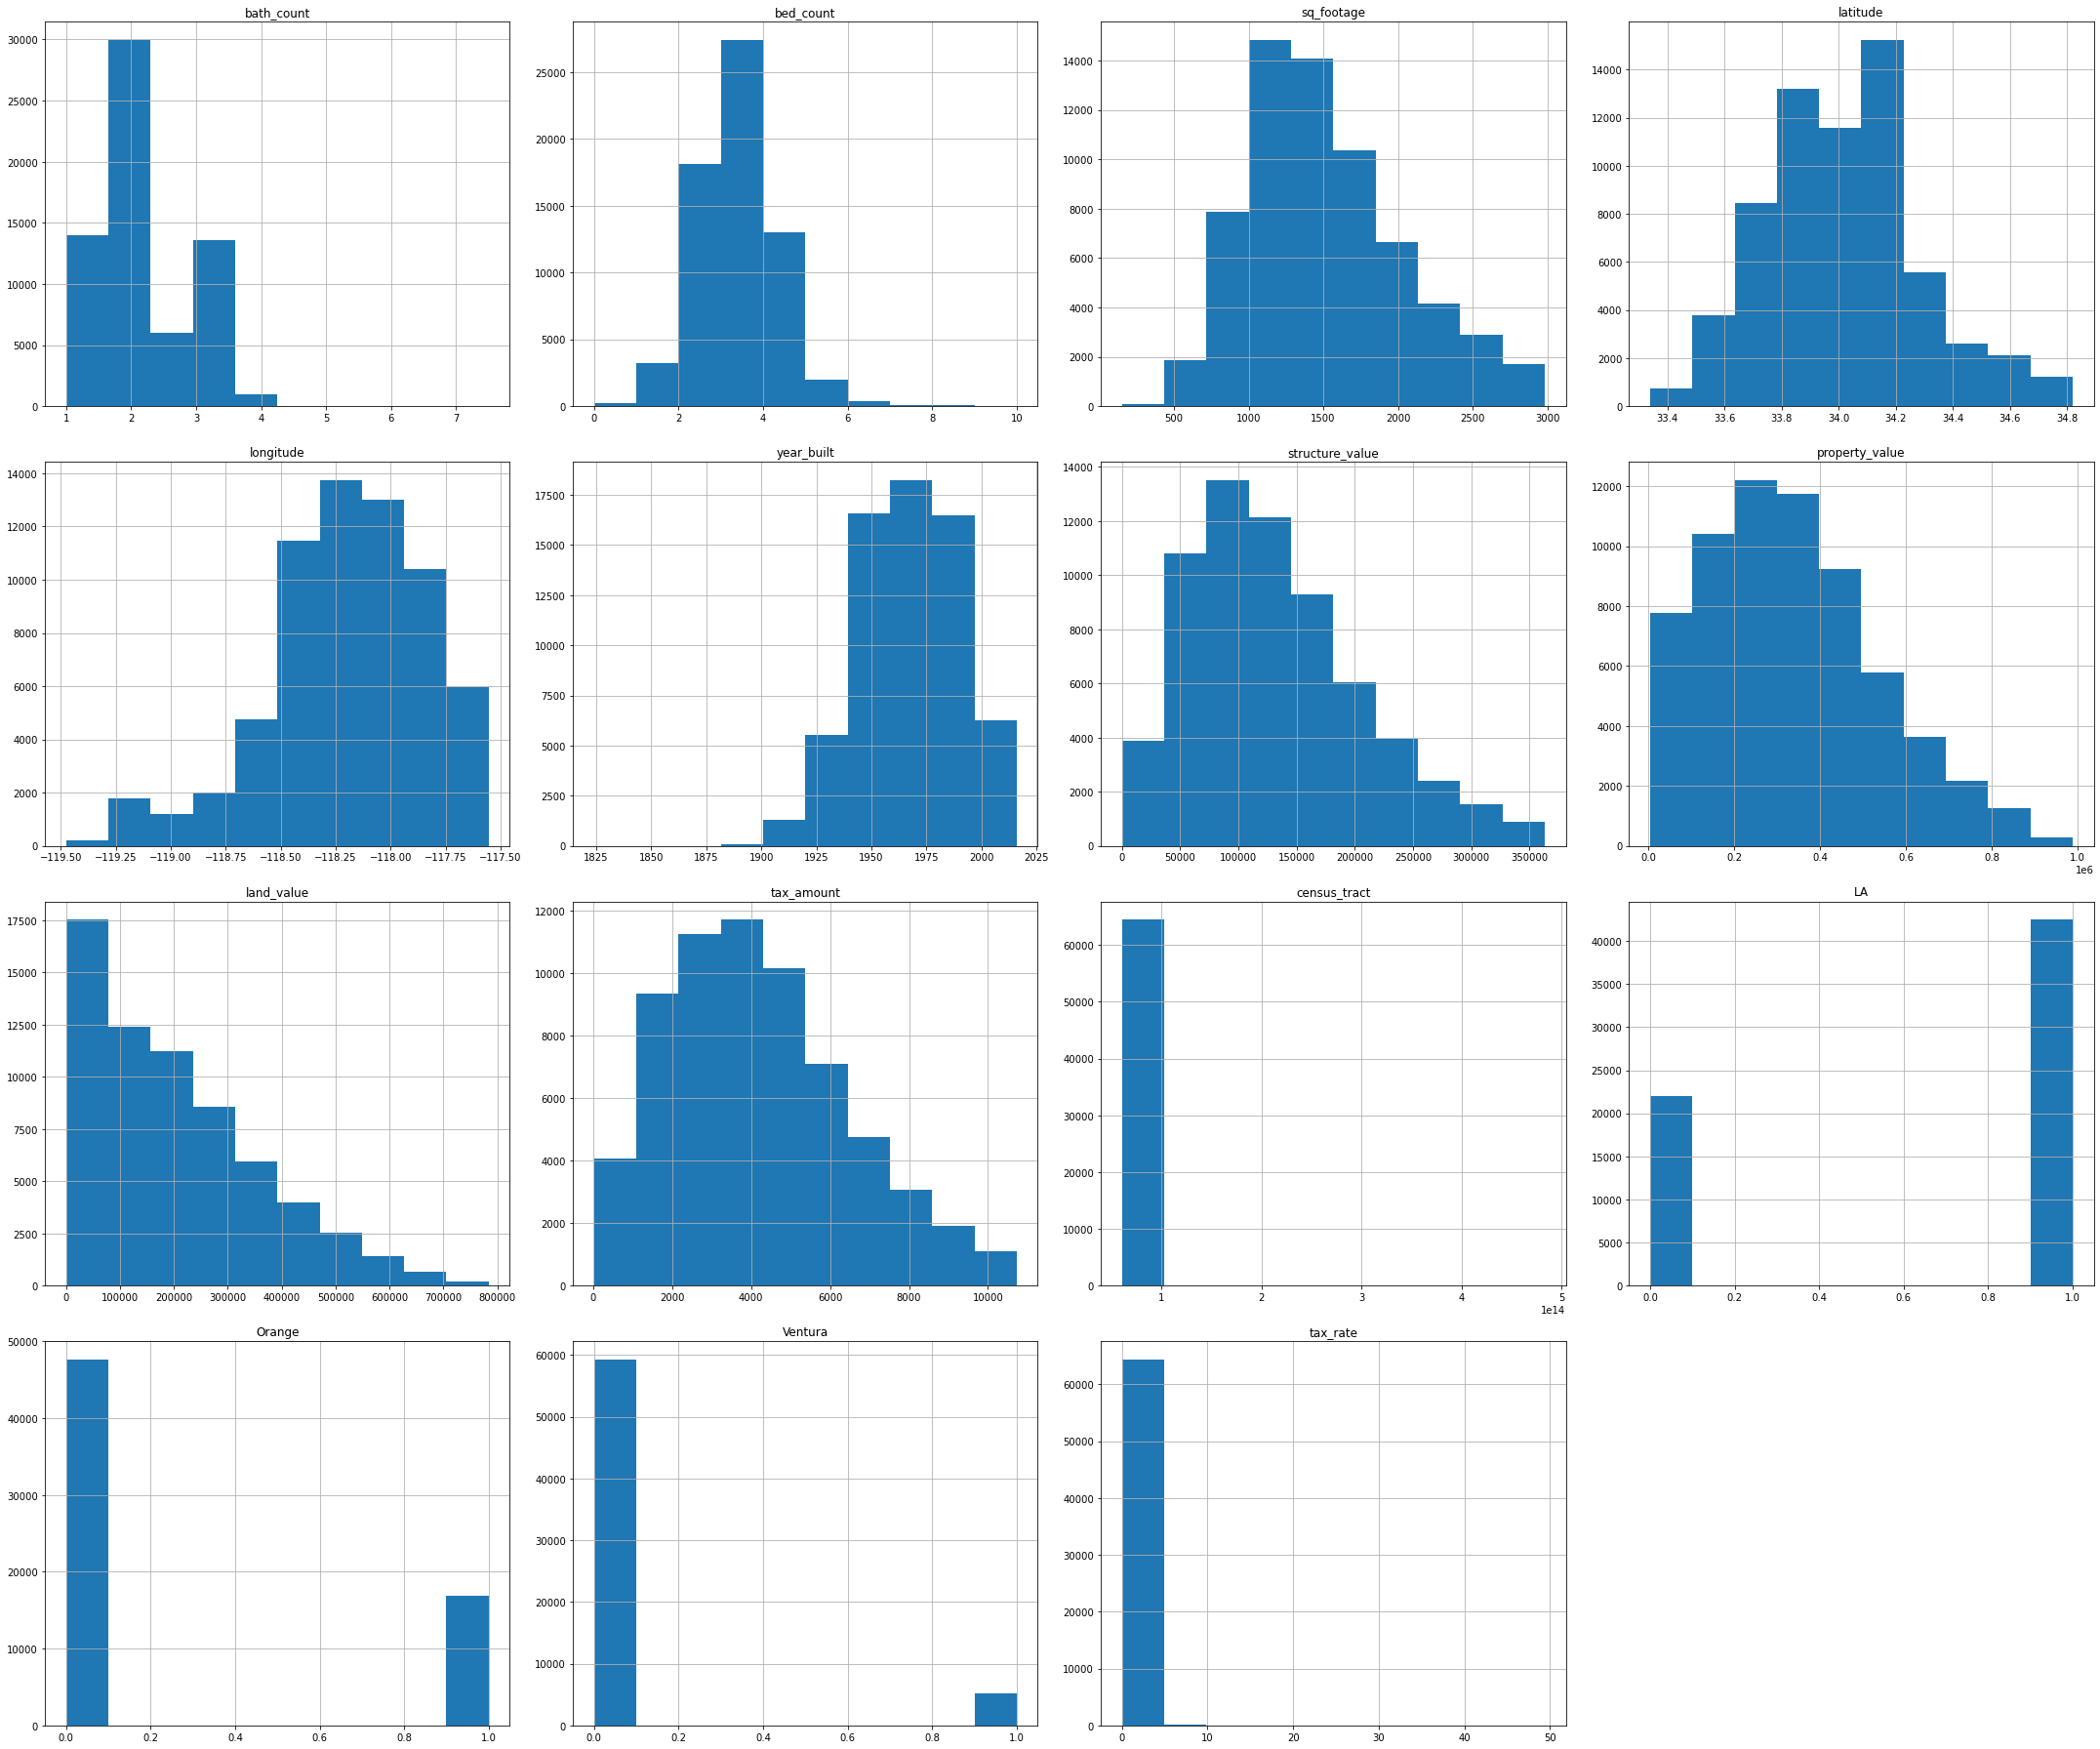

In [13]:
# visualize distributions after outlier removal
zillow_df.drop(columns=['target', 'parcel_id']).hist(figsize=(30,25))
plt.tight_layout()
plt.show()

In [ ]:
===============================================================
# PREPARE TAKEAWAYS:
===============================================================
#Removal of the outliers improved the distributions extremely well.
#The data now looks normally distributed/expected forits associated column

## SPLITTING AND SCALING THE DATA
#Utilized a MinMaxScaller for the data to transform each value in the column proprtionately with the desirable range 0 and 1. 
#Additionally we are dealing with different units for values (dollar, sq ft)

In [14]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = f.train_validate_test(zillow_df, target='target')


In [15]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = f.Min_Max_Scaler(X_train, X_validate, X_test)


In [16]:
#Made a copy of the y_train series and copied to df
y_train_scaled = y_train
# # combine target to DataFrame for exploration
train_scaled_comp = pd.concat((X_train_scaled, y_train_scaled), axis=1)


#=============================================================================
# Initial thoughts and Hypothesis
#=============================================================================

In [ ]:


 There seems to be a logical correlation to property location with the gleaning that has been done so far. 
    However, a statistical test will help settle whether any correlation is the result of chance. 
    Below you will find the null and alternate hypothesizes for the variables explored.
 
 A statistical test will be performed and then compared against an established significance level.
 
 H0: There is no linear correlation between the variables explored and log error.

 Ha: There is a linear correlation between the variables explored and log error.
 
alpha = 0.05

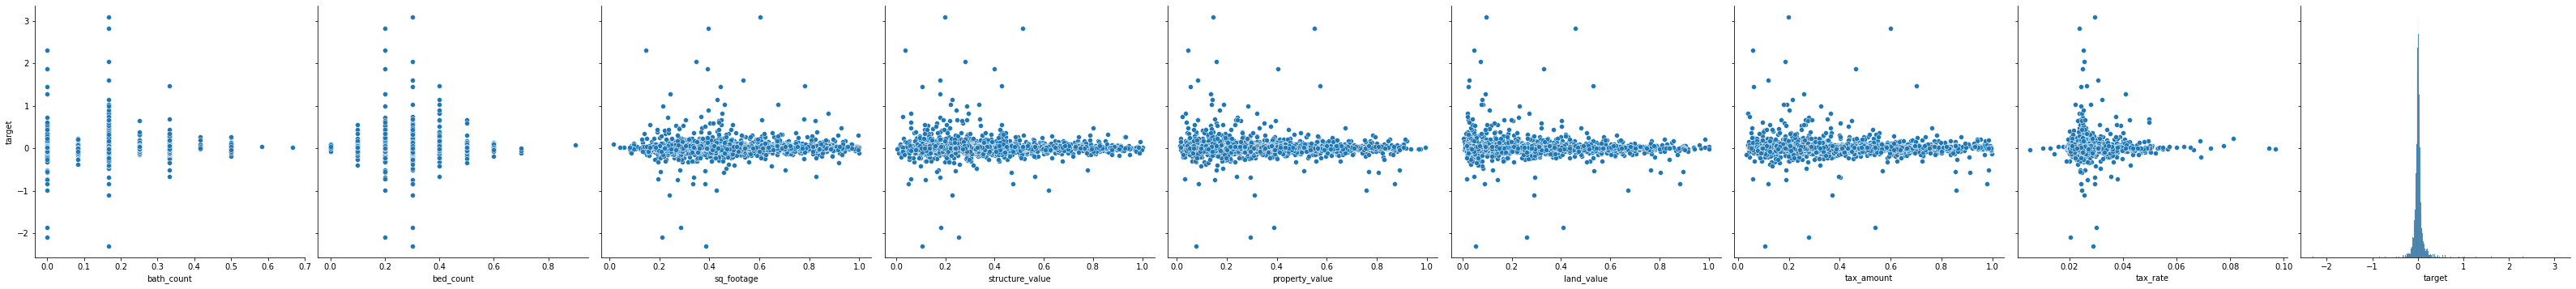

In [17]:
# create a pairplot for quick glance at variable interaction
sns.pairplot(train_scaled_comp.drop(
    columns=['census_tract', 'LA', 'Ventura', 'Orange', 'latitude', 'longitude',
             'parcel_id', 'year_built'])\
             .sample(n=3000, random_state=19), y_vars=['target'], height=5, aspect=1)

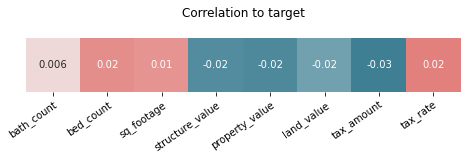

In [18]:
f.target_heat(train_scaled_comp.drop(
    columns=['census_tract', 'LA', 'Ventura', 'Orange', 'latitude', 'longitude',
             'parcel_id', 'year_built']), 'target')

## Hypothesis Testing Correlation to Target

In [19]:
# perform statistical tests on strongest correlations according to heatmap
f.corr_test(train_scaled_comp, 'bed_count', 'target')
f.corr_test(train_scaled_comp, 'sq_footage', 'target')
f.corr_test(train_scaled_comp, 'bath_count', 'target')
f.corr_test(train_scaled_comp, 'land_value', 'target')

   pearson r = 0.016
+--------------------+

        Due to p-value 0.003 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "bed_count" and "target."
        
   pearson r = 0.015
+--------------------+

        Due to p-value 0.0053 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "sq_footage" and "target."
        
   pearson r = 0.0059
+--------------------+

        Due to p-value 0.26 being greater than our significance level of 0.05, we fail to reject the null hypothesis 
        that there is not a linear correlation between "bath_count" and "target."
        
   pearson r = -0.019
+--------------------+

        Due to p-value 0.00024 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "land_value" and "target."
       

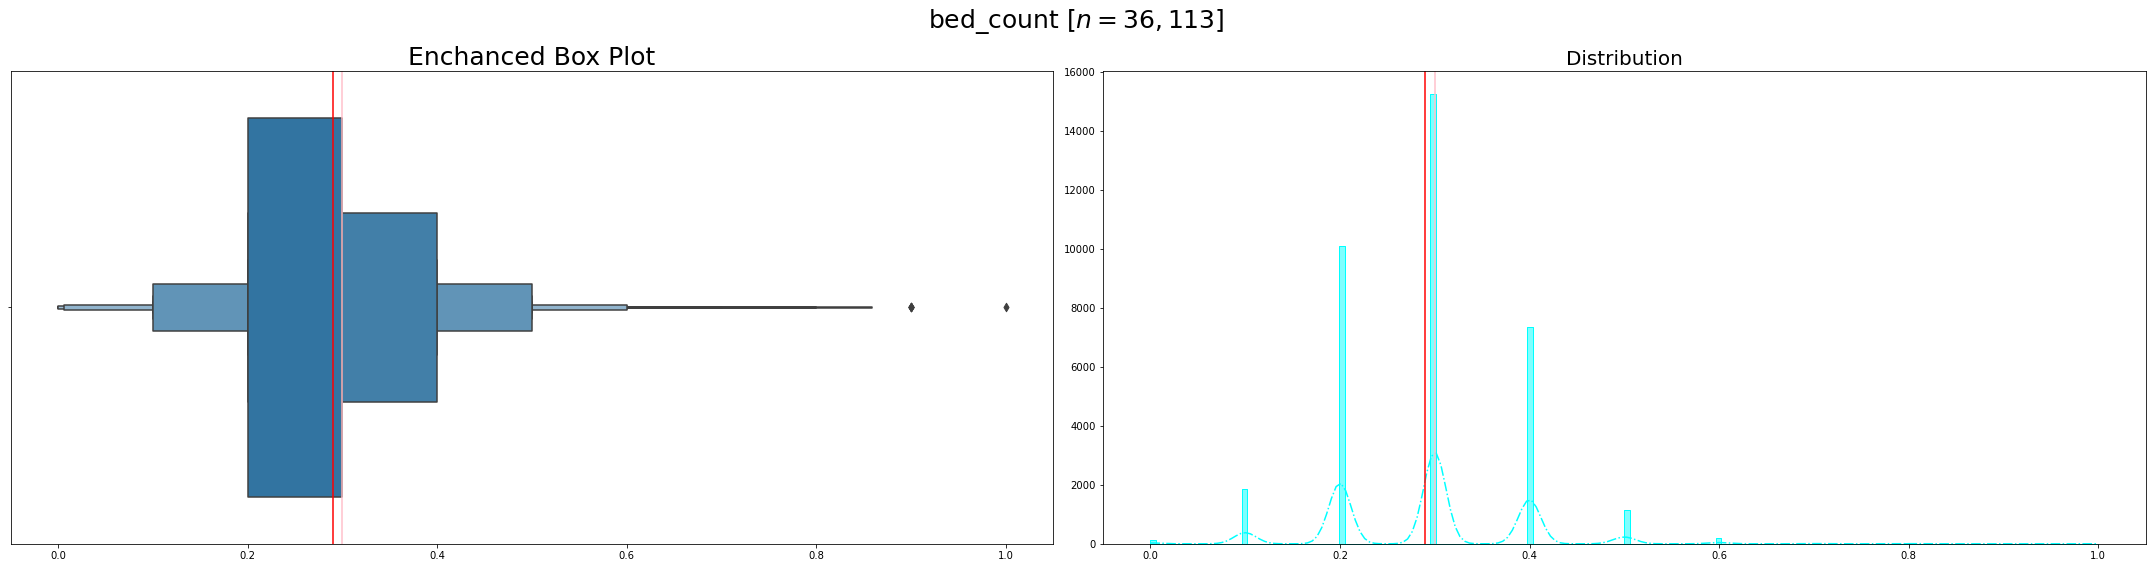

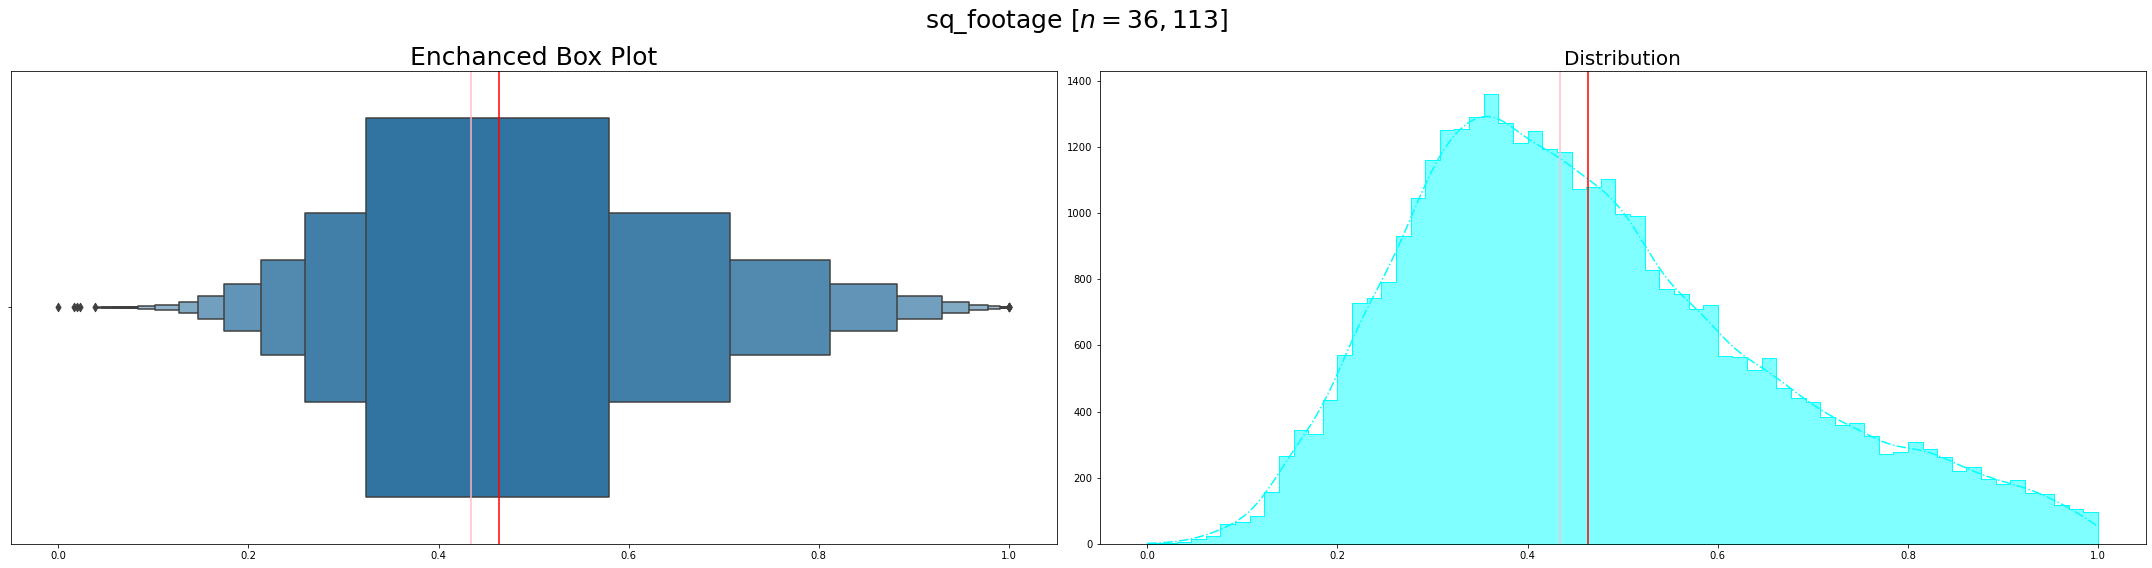

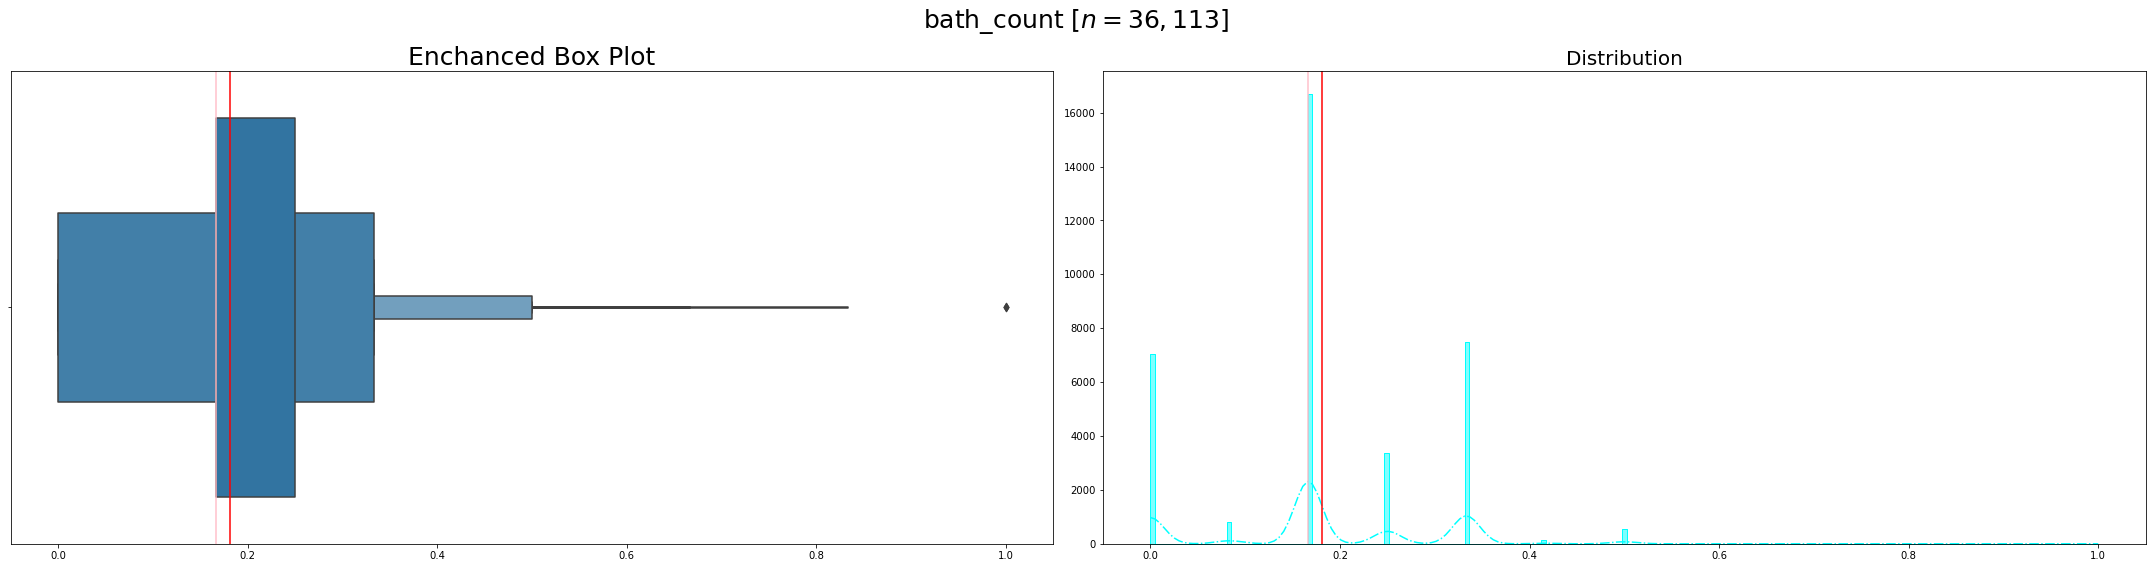

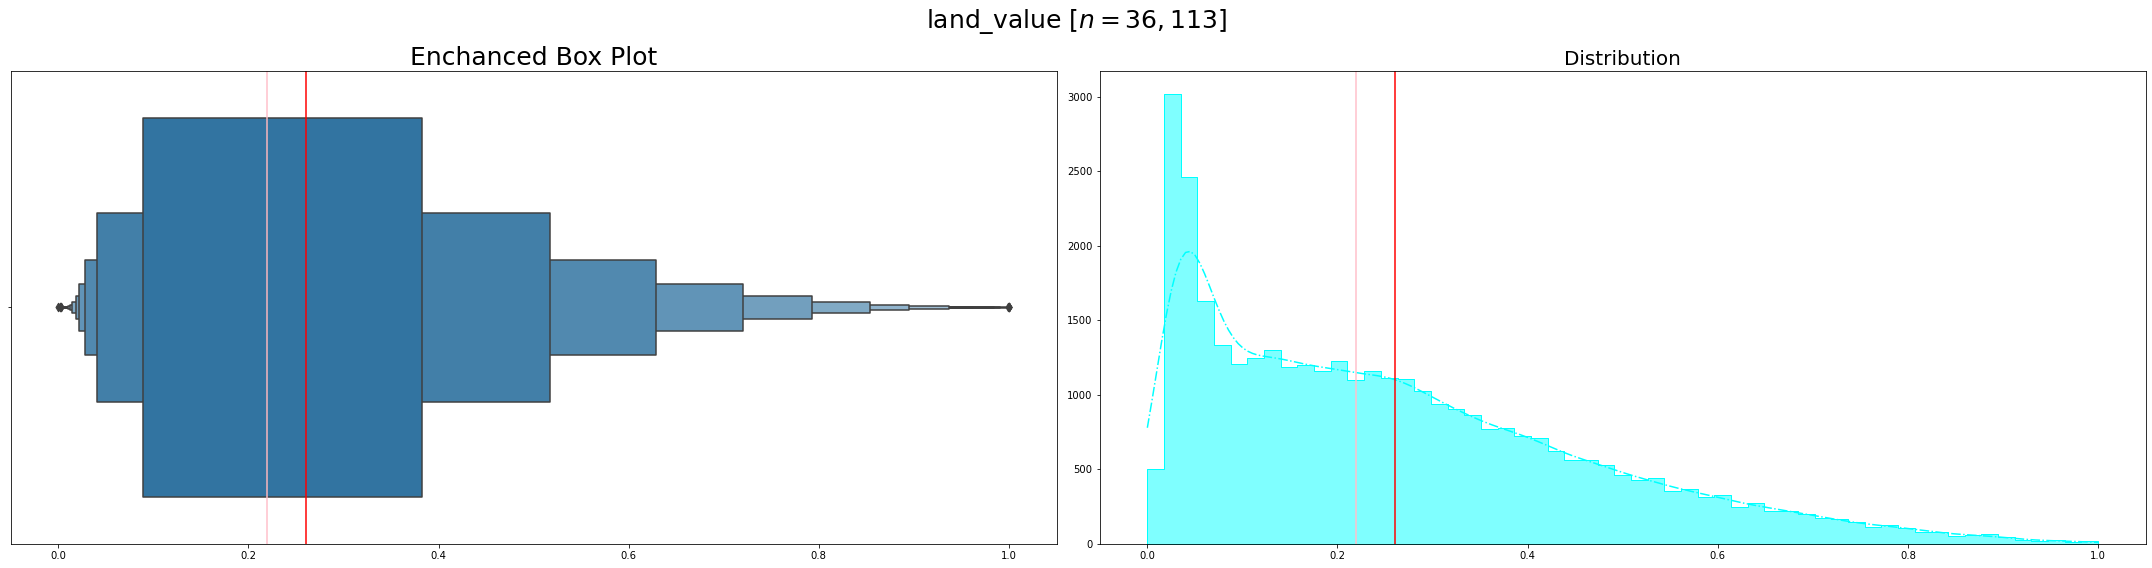

In [20]:
# look more closely at strongest correlations to log_error
f.plot_univariate(train_scaled_comp, 'bed_count')
f.plot_univariate(train_scaled_comp, 'sq_footage')
f.plot_univariate(train_scaled_comp, 'bath_count')
f.plot_univariate(train_scaled_comp, 'land_value')

## THOUGHTS/OBSERVATIONS/TAKEAWAYS

In [ ]:
# By observing the plot of variables to the target log_error, there is no clear relationship
#  made evident with the individual variables. Looking at the pair plot, all of the variables
#  show a significant range in logerror individually. There is no strong correlation between
#  the target, log error, and the other variables. There is an apparent significantly strong
#  negative correlation between bath_count and land_value with the target. This may be due
#  to a unique interaction of the variables that are having an effect on log_error. Clustering
#  will aid in methods of exploration to define any possible relationships evident between the
#  target and variables presented.

## Cluster Exploration

In [ ]:
# With the use of my initial hypothesis that were previously stated, methods of clustering
#  are utilized to establish any meaningful insight into possible key drivers of the target
#  log_error.
# 
# Iterations will be performed in variable exploration in order to identify clusters that
#  not only identify drivers of the target but perhaps even support future modeling
#  predictions. 
# 
# An analysis of variance test (ANOVA) will aid in cluster comparison. The elbow plot
#  method will be utilized for clustering where k is the point of least change to
#  inertia.

In [ ]:
# set col_list for cluster formation
col_list_scaled = ['latitude', 'longitude']
# create DataFrame for explored variables
explore_df = train_scaled_comp[col_list_scaled]

In [ ]:
# create plot to use elbow method to find best k
f.elbow_plot(explore_df, col_list_scaled)

In [ ]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = f.explore_clusters(explore_df, col_list_scaled, k=5)


In [ ]:
# create plot to view clusters for lat_long_clstr
f.plot_clusters(cluster_df, center_df, 'latitude', 'longitude')

In [ ]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train_scaled_comp.target), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].target,
                      samples[samples.cluster == 1].target,
                      samples[samples.cluster == 2].target,
                      samples[samples.cluster == 3].target,
                      samples[samples.cluster == 4].target)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')

In [ ]:
# Striking out with the initial hypothesis, below the relationship of count of
#  bedrooms and squarefootage will be clustered and explored
#  against the target. The clusters will then be compared using an ANOVA test.

In [ ]:
# set col_list for cluster formation
col_list_scaled = ['bed_count', 'sq_footage']
# create DataFrame for explored variables
explore_df = train_scaled_comp[col_list_scaled]



In [ ]:
# create plot to use elbow method to find best k
f.elbow_plot(explore_df, col_list_scaled)

In [ ]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = f.explore_clusters(explore_df, col_list_scaled, k=5)


In [ ]:
# create plot to view clusters for lat_long_clstr
f.plot_clusters(cluster_df, center_df, 'bed_count', 'sq_footage')



In [ ]:

# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train_scaled_comp.target), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].target,
                      samples[samples.cluster == 1].target,
                      samples[samples.cluster == 2].target,
                      samples[samples.cluster == 3].target,
                      samples[samples.cluster == 4].target)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


In [ ]:

# add cluster to DataFrame for feature exploration
train_scaled_comp['bed_sq_foot_clstr'] = cluster_df.cluster
train_scaled_comp = pd.get_dummies(train_scaled_comp, columns=['bed_sq_foot_clstr'], drop_first=True)


## Latitude/ Longitude/ Property Value

In [ ]:
# set col_list for cluster formation
col_list_scaled = ['latitude', 'longitude', 'property_value']
# create DataFrame for explored variables
explore_df = train_scaled_comp[col_list_scaled]

In [ ]:
# create plot to use elbow method to find best k
f.elbow_plot(explore_df, col_list_scaled)

In [ ]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = f.explore_clusters(explore_df, col_list_scaled, k=5)

In [ ]:
# create plot to view clusters for lat_long_clstr
f.plot_three_d_clusters(cluster_df, center_df, 'latitude', 'longitude', 'property_value')

In [ ]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train_scaled_comp.target), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].target,
                      samples[samples.cluster == 1].target,
                      samples[samples.cluster == 2].target,
                      samples[samples.cluster == 3].target,
                      samples[samples.cluster == 4].target)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')

In [ ]:
# add cluster to DataFrame for feature exploration
train_scaled_comp['lat_long_pv_clstr'] = cluster_df.cluster
train_scaled_comp = pd.get_dummies(train_scaled_comp, columns=['lat_long_pv_clstr'], drop_first=True)


# BEDCOUNT VS TAX RATE 

In [ ]:
# set col_list for cluster formation
col_list_scaled = ['bed_count', 'tax_rate']
# create DataFrame for explored variables
explore_df = train_scaled_comp[col_list_scaled]


In [ ]:
# create plot to use elbow method to find best k
f.elbow_plot(explore_df, col_list_scaled)

In [ ]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = f.explore_clusters(explore_df, col_list_scaled, k=5)

In [ ]:

# create plot to view clusters for lat_long_clstr
f.plot_clusters(cluster_df, center_df, 'bed_count', 'tax_rate')



In [ ]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train_scaled_comp.target), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].target,
                      samples[samples.cluster == 1].target,
                      samples[samples.cluster == 2].target,
                      samples[samples.cluster == 3].target,
                      samples[samples.cluster == 4].target)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')

In [ ]:
# add cluster to DataFrame for feature exploration
train_scaled_comp['bed_taxrate_clstr'] = cluster_df.cluster
train_scaled_comp = pd.get_dummies(train_scaled_comp, columns=['bed_taxrate_clstr'], drop_first=True)


## Land Value Vs Census Tract

In [ ]:
# set col_list for cluster formation
col_list_scaled = ['land_value', 'census_tract']
# create DataFrame for explored variables
explore_df = train_scaled_comp[col_list_scaled]



In [ ]:
# create plot to use elbow method to find best k
f.elbow_plot(explore_df, col_list_scaled)

In [ ]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = f.explore_clusters(explore_df, col_list_scaled, k=5)



In [ ]:

# create plot to view clusters for lat_long_clstr
f.plot_clusters(cluster_df, center_df, 'land_value', 'census_tract')



In [ ]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train_scaled_comp.target), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].target,
                      samples[samples.cluster == 1].target,
                      samples[samples.cluster == 2].target,
                      samples[samples.cluster == 3].target,
                      samples[samples.cluster == 4].target)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')

In [ ]:

# add cluster to DataFrame for feature exploration
train_scaled_comp['land_val_census_clstr'] = cluster_df.cluster
train_scaled_comp = pd.get_dummies(train_scaled_comp, columns=['land_val_census_clstr'], drop_first=True)



## CLUSTER TAKEAWAYS:
- The only cluster that did not reject the null hypothesis was the cluster for latitude and longitude
- All others accepted the null hypothesis

## Modeling

In [ ]:
# let's find the baseline logerror...
# train_scaled_comp.target.mean()

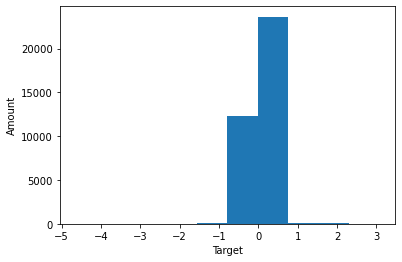

0.01

In [21]:
plt.hist(y_train)
plt.xlabel("Target")
plt.ylabel("Amount")
plt.show()

round((y_train.mean()), 2)
#521221.76
round(y_train.median(), 2)

In [22]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train_df = pd.DataFrame(y_train)
y_validate_df = pd.DataFrame(y_validate)

# 1. Predict z_pred_mean
z_pred_mean = y_train_df['target'].mean()
y_train_df['z_pred_mean'] = z_pred_mean
y_validate_df['z_pred_mean'] = z_pred_mean

# 2. compute z_pred_median
z_pred_median = y_train_df['target'].median()
y_train_df['z_pred_median'] = z_pred_median
y_validate_df['z_pred_median'] = z_pred_median

# 3. RMSE of z_pred_mean
rmse_train = mean_squared_error(y_train_df.target, y_train_df.z_pred_mean)**(.5)
rmse_validate = mean_squared_error(y_validate_df.target, y_validate_df.z_pred_mean)**(.5)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of z_pred_median
rmse_train = mean_squared_error(y_train_df.target, y_train_df.z_pred_median)**(.5)
rmse_validate = mean_squared_error(y_validate_df.target, y_validate_df.z_pred_median)**(.5)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.15
RMSE using Median
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.15


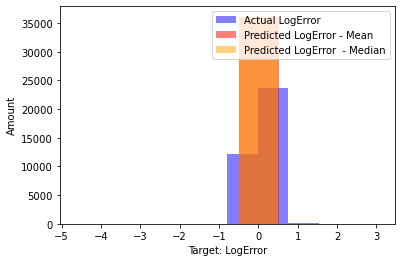

In [23]:
# plot to visualize actual vs predicted. 
plt.hist(y_train_df.target, color='blue', alpha=.5, label="Actual LogError")
plt.hist(y_train_df.z_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted LogError - Mean")
plt.hist(y_train_df.z_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted LogError  - Median")
plt.xlabel("Target: LogError")
plt.ylabel("Amount")
plt.legend()
plt.show()

In [ ]:
# # We need y_train and y_validate to be dataframes to append the new columns with predicted values. 

# y_validate_scaled = y_validate.copy()
# y_test_scaled = y_test.copy()


# y_train_scaled = pd.DataFrame(y_train_scaled)
# y_validate_scaled = pd.DataFrame(y_validate_scaled)
# y_test_scaled = pd.DataFrame(y_test_scaled)

In [ ]:
# # We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
# y_train_scaled = pd.DataFrame(y_train_scaled)
# y_validate_scaled = pd.DataFrame(y_validate_scaled)
# y_test_scaled = pd.DataFrame(y_test_scaled)

In [ ]:
# # Predict av_pred_mean
# av_pred_mean = y_train_scaled['target'].mean()
# y_train_scaled['baseline'] = av_pred_mean
# y_validate_scaled['baseline'] = av_pred_mean
# y_test_scaled['baseline'] = av_pred_mean


In [ ]:
y_train

In [ ]:
# # RMSE of av_pred_mean
# rmse_train = mean_squared_error(y_train['target'], y_train['baseline']) ** 0.5
# rmse_validate = mean_squared_error(y_validate_scaled['target'], y_validate_scaled['baseline']) ** 0.5


In [ ]:
# # How did the baseline mean perform
# print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
#       "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

In [26]:
y_validate_df

,target,z_pred_mean,z_pred_median
49615,0.383462,0.015053,0.00571
70510,0.026383,0.015053,0.00571
50249,-0.004832,0.015053,0.00571
49338,0.001950,0.015053,0.00571
51170,0.033238,0.015053,0.00571
...,...,...,...
33566,0.079425,0.015053,0.00571
64521,-0.006252,0.015053,0.00571
7005,0.075027,0.015053,0.00571
56036,0.080748,0.015053,0.00571


In [27]:
# Clean it up now
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate.round(4),
    'r^2_validate': explained_variance_score(y_validate_df['target'], y_validate_df['z_pred_mean'])}])
metric_df


,model,rmse_validate,r^2_validate
0,mean_baseline,0.1517,0.0


In [28]:
X_validate_scaled

,parcel_id,bath_count,bed_count,sq_footage,latitude,longitude,year_built,structure_value,property_value,land_value,tax_amount,census_tract,LA,Orange,Ventura,tax_rate
49615,0.021046,0.083333,0.3,0.611679,0.346652,0.820036,0.677083,0.110042,0.056912,0.024530,0.092370,0.297468,0.0,1.0,0.0,0.034149
70510,0.000751,0.166667,0.3,0.476277,0.586058,0.539435,0.671875,0.167512,0.081530,0.028876,0.097979,0.000352,1.0,0.0,0.0,0.025611
50249,0.011747,0.000000,0.2,0.299270,0.320042,0.668397,0.614583,0.190957,0.348617,0.354475,0.396222,0.006374,1.0,0.0,0.0,0.024604
49338,0.002800,0.166667,0.3,0.340876,0.701395,0.481562,0.729167,0.438492,0.292174,0.168499,0.373647,0.011084,1.0,0.0,0.0,0.027677
51170,0.008754,0.333333,0.3,0.610949,0.594650,0.639936,0.932292,0.413341,0.636359,0.613778,0.639753,0.002699,1.0,0.0,0.0,0.021785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33566,0.021758,0.166667,0.3,0.690876,0.220335,0.812777,0.687500,0.166537,0.091390,0.041749,0.143733,0.297164,0.0,1.0,0.0,0.033546
64521,0.010586,0.166667,0.3,0.364599,0.371933,0.676253,0.697917,0.146168,0.068206,0.021995,0.110856,0.006124,1.0,0.0,0.0,0.034398
7005,0.025890,0.250000,0.2,0.516788,0.233793,0.775509,0.854167,0.397010,0.281969,0.174893,0.308816,0.297642,0.0,1.0,0.0,0.023677
56036,0.002895,0.166667,0.3,0.542336,0.715501,0.524232,0.739583,0.444242,0.209746,0.061987,0.285347,0.011080,1.0,0.0,0.0,0.029377


In [29]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train_df['target'])

# predict train
y_train_df['z_pred_mean'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_df['target'], y_train_df['z_pred_mean']) ** (1/2)
# predict validate
y_validate_df['z_pred_mean'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_df['target'], y_validate_df['z_pred_mean']) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15848969614842048 
Validation/Out-of-Sample:  0.8776390310782849


In [30]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate_df['target'], y_validate_df['z_pred_mean'])}, ignore_index=True)
metric_df


,model,rmse_validate,r^2_validate
0,mean_baseline,0.151700,0.000000
1,OLS lm 1,0.877639,-32.578409


In [ ]:
# # use RFE to find best cluster for analysis
# X = train_scaled_comp
# y = train['target']

# lm = LinearRegression()
# rfe = RFE(estimator=lm, n_features_to_select=4)
# rfe.fit(X, y)

# pd.Series(dict(zip(X.columns, rfe.ranking_))).sort_values()

## LASSO + LARS

In [31]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train_df['target'])

# predict train
y_train_df['z_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_df['target'], y_train_df['z_pred_lars'])**(.5)

# predict validate
y_validate_df['z_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_df['target'], y_validate_df['z_pred_lars'])**(.5)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.1586882468905443 
Validation/Out-of-Sample:  0.15145112372717687


In [32]:
metric_df = metric_df.append(
    {
    'model': 'LASSO + LARS',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate_df['target'], y_validate_df['z_pred_lars'])}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,0.151700,0.000000
1,OLS lm 1,0.877639,-32.578409
2,LASSO + LARS,0.151451,0.000000


## POLYNOMIAL REGRESSION MODEL

In [35]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [37]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train_df.target)

# predict train
y_train_df['targ_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_df.target, y_train_df.targ_pred_lm2)**(1/2)

# predict validate
y_validate_df['targ_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_df.target, y_validate_df.targ_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.15798655147521945 
Validation/Out-of-Sample:  17579.217208776234


In [38]:
metric_df = metric_df.append(
    {
    'model': 'Polynomial Regression',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate_df['target'], y_validate_df['targ_pred_lm2'])}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,0.151700,0.000000e+00
1,OLS lm 1,0.877639,-3.257841e+01
2,LASSO + LARS,0.151451,0.000000e+00
3,Polynomial Regression,17579.217209,-1.347181e+10


## Polynomial Regressor

In [60]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled)
X_test_degree3 = pf.transform(X_test_scaled)

In [61]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train_df.target)

# predict train
y_train_df['targ_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_df.target, y_train_df.targ_pred_lm3)**(1/2)

# predict validate
y_validate_df['targ_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_df.target, y_validate_df.targ_pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.15613645647111138 
Validation/Out-of-Sample:  241609254.61817953


In [62]:
metric_df = metric_df.append(
    {
    'model': 'Polynomial Regression',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate_df['target'], y_validate_df['targ_pred_lm3'])}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,1.517000e-01,0.000000e+00
1,OLS lm 1,8.776390e-01,-3.257841e+01
2,LASSO + LARS,1.514511e-01,0.000000e+00
3,Polynomial Regression,1.757922e+04,-1.347181e+10
4,Polynomial Regression,2.416093e+08,-2.544803e+18


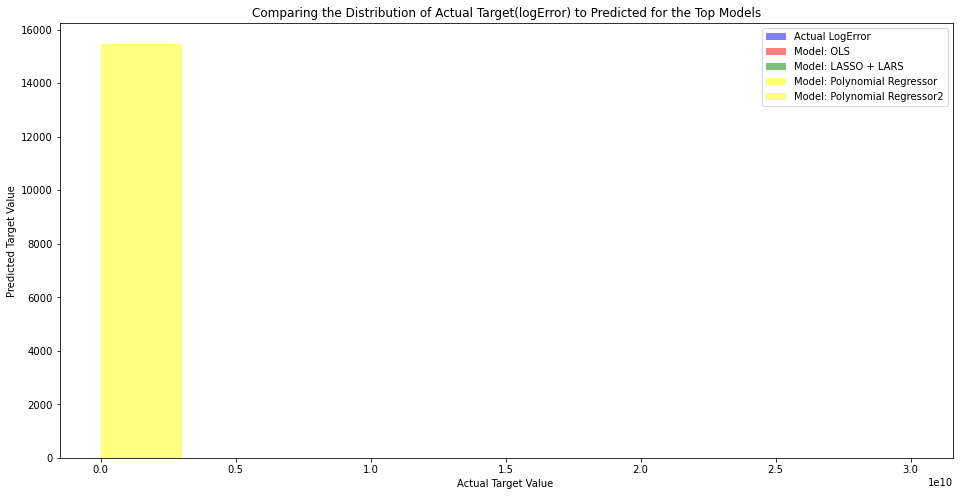

In [63]:

# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate_df.target, color='blue', alpha=.5, label="Actual LogError")
plt.hist(y_validate_df.z_pred_mean, color='red', alpha=.5, label="Model: OLS")
plt.hist(y_validate_df.z_pred_lars, color='green', alpha=.5, label="Model: LASSO + LARS")
plt.hist(y_validate_df.targ_pred_lm2, color='yellow', alpha=.5, label="Model: Polynomial Regressor")
plt.hist(y_validate_df.targ_pred_lm3, color='yellow', alpha=.5, label="Model: Polynomial Regressor2")
plt.xlabel("Actual Target Value ")
plt.ylabel("Predicted Target Value")
plt.title("Comparing the Distribution of Actual Target(logError) to Predicted for the Top Models")
plt.legend()
plt.show()


In [64]:

########## COMPARING THE MODELS DF:
metric_df[['model', 'rmse_validate']]

,model,rmse_validate
0,mean_baseline,1.517000e-01
1,OLS lm 1,8.776390e-01
2,LASSO + LARS,1.514511e-01
3,Polynomial Regression,1.757922e+04
4,Polynomial Regression,2.416093e+08


In [65]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['z_pred_mean'] = lm.predict(X_test_scaled)

# # evaluate: rmse
rmse_test = mean_squared_error(y_test.target, y_test.z_pred_mean) ** (.5)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

# # ========================

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  0.1509209333841309


In [69]:
# predict on test
y_test['z_pred_lars'] = lars.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.target, y_test.z_pred_lars) ** (.5)

print("RMSE for LARS Model using LARSLASSO\nOut-of-Sample Performance: ", rmse_test)


RMSE for LARS Model using LARSLASSO
Out-of-Sample Performance:  0.1510335702468451


In [70]:
y_test['targ_pred_lm2'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.target, y_test.targ_pred_lm2) ** (.5)

print("RMSE for Polynomial Regressor Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)


RMSE for Polynomial Regressor Model using LinearRegression
Out-of-Sample Performance:  0.1509209333841309


In [71]:
y_test['targ_pred_lm3'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.target, y_test.targ_pred_lm3) ** (.5)

print("RMSE for Polynomial Regressor Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)


RMSE for Polynomial Regressor Model using LinearRegression
Out-of-Sample Performance:  0.1509209333841309


## Conclusion

-The models tested and presented today were not able to beat the baseline 
-Regarding use of cluster exploration: It appeared the the clusters comprised of two features did not pose much value to later modeling. As a result they were npt used in the modeling.
-With More time:
    >Revisit Cluster Exploration and tackles more features
    >Explore additional trends in clustering
    >Revisit clusters with features such as latitude, longitude, and property value